Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.


/usr/local/lib/python3.11/dist-packages/utilsforecast/processing.py:384: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/usr/local/lib/python3.11/dist-packages/utilsforecast/processing.py:440: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  freq = pd.tseries.frequencies.to_offset(freq)


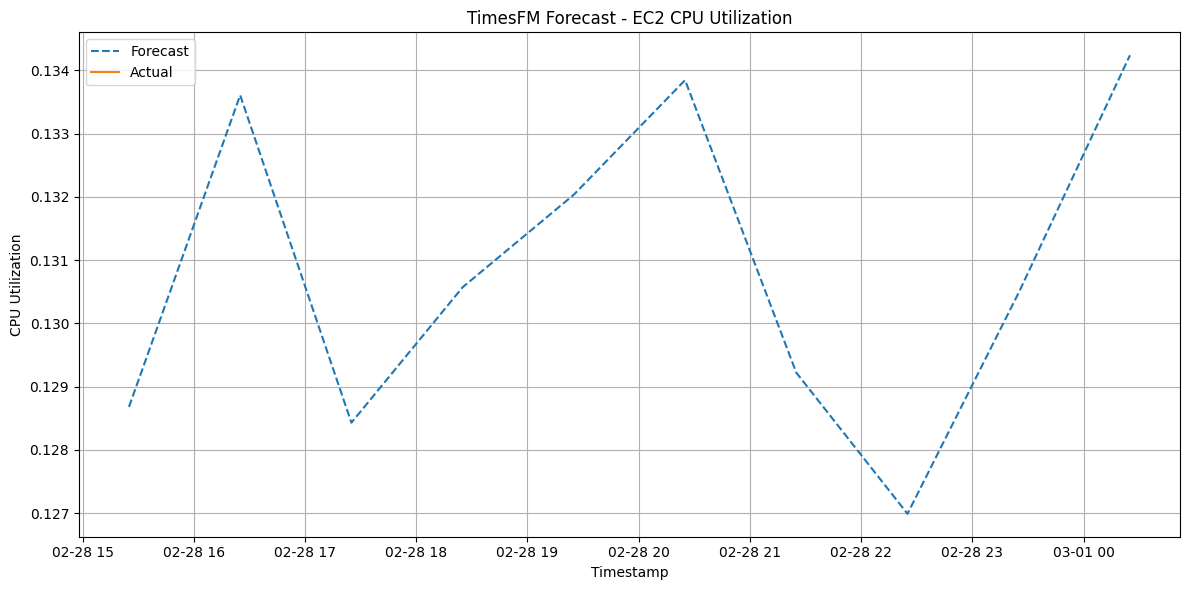

Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/local/lib/python3.11/dist-packages/utilsforecast/processing.py:384: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/usr/local/lib/python3.11/dist-packages/utilsforecast/processing.py:440: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  freq = pd.tseries.frequencies.to_offset(freq)


Finished preprocessing dataframe.
Finished forecasting.
Processing dataframe with multiple processes.


/usr/local/lib/python3.11/dist-packages/utilsforecast/processing.py:384: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/usr/local/lib/python3.11/dist-packages/utilsforecast/processing.py:440: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  freq = pd.tseries.frequencies.to_offset(freq)


Finished preprocessing dataframe.
Finished forecasting.
MAE: 0.0231


/usr/local/lib/python3.11/dist-packages/utilsforecast/processing.py:384: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/usr/local/lib/python3.11/dist-packages/utilsforecast/processing.py:440: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  freq = pd.tseries.frequencies.to_offset(freq)


In [8]:
# Install TimesFM
!pip install timesfm --quiet

# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
from timesfm import TimesFm, TimesFmHparams, TimesFmCheckpoint
from sklearn.metrics import mean_absolute_error

# Load EC2 CPU utilization data
url = "https://raw.githubusercontent.com/numenta/NAB/refs/heads/master/data/realAWSCloudwatch/ec2_cpu_utilization_24ae8d.csv"
df = pd.read_csv(url)
df = df.rename(columns={"timestamp": "ds", "value": "y"})
df["ds"] = pd.to_datetime(df["ds"])
df["unique_id"] = "ec2_cpu"

# Save original for evaluation
original_df = df.copy()

# Initialize TimesFM
tfm = TimesFm(
    hparams=TimesFmHparams(
        backend="cpu",
        per_core_batch_size=32,
        horizon_len=10,
        num_layers=50,
        use_positional_embedding=False,
        context_len=512,
    ),
    checkpoint=TimesFmCheckpoint(
        huggingface_repo_id="google/timesfm-2.0-500m-pytorch"
    ),
)

# Forecast
preds_df = tfm.forecast_on_df(
    inputs=df,
    freq="H",
    value_name="y",
    num_jobs=-1
)

# Merge predictions with original for plotting
merged = preds_df.merge(original_df, on=["unique_id", "ds"], how="left")

# Plot forecast
subset = merged.set_index("ds")
plt.figure(figsize=(12, 6))
plt.plot(subset["timesfm"], label="Forecast", linestyle="--")
plt.plot(subset["y"], label="Actual")
plt.title("TimesFM Forecast - EC2 CPU Utilization")
plt.xlabel("Timestamp")
plt.ylabel("CPU Utilization")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Cross-validation function
def cross_validation_timesfm(df, h, n_windows, target_col, freq):
    predictions = []
    total_length = len(df)
    for i in range(n_windows):
        end_idx = total_length - i * h
        start_idx = max(0, end_idx - 512)
        cv_slice = df.iloc[start_idx:end_idx]
        preds = tfm.forecast_on_df(
            inputs=cv_slice,
            freq=freq,
            value_name=target_col,
            num_jobs=-1
        )
        predictions.append(preds)
    return pd.concat(predictions).sort_values(["unique_id", "ds"])

# Run CV
cv_preds = cross_validation_timesfm(
    df=original_df,
    h=24,
    n_windows=3,
    target_col="y",
    freq="H"
)

# Evaluate (safe)
merged_cv = cv_preds.merge(original_df, on=["unique_id", "ds"], how="left")
merged_cv = merged_cv.dropna(subset=["y", "timesfm"])  # Drop rows with NaNs

actual = merged_cv["y"].values
forecast = merged_cv["timesfm"].values
mae = mean_absolute_error(actual, forecast)

print(f"MAE: {mae:.4f}")